# Fashion-MNIST analysis
_Franciszek Urbański_

## Dataset overview
To quote [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist):
> Fashion-MNIST is a dataset of Zalando's article images [...]. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

Let's start the analysis by setting up our environmens - some basic imports, setting a value to be used for `random_state` in some algorithms and setting a seed value for `numpy`'s RNG (for reproducibility). Finally, we'll load our dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RS = 20040304
np.random.seed(RS)

df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

I downloaded the dataset from [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist). It is split into two parts - 60'000 samples to be used for training, and 10'000 for testing. Each sample consists of 785 columns, 784 of which are darkness values (0 to 255) for consecutive pixels of the 28x28 image, while one is the label, representing the category of the clothing item:

| label | category      |
|-------|-------------------|
| 0     | T-shirt/top       |
| 1     | Trousers          |
| 2     | Pullover          |
| 3     | Dress             |
| 4     | Coat              |
| 5     | Sandal            |
| 6     | Shirt             |
| 7     | Sneaker           |
| 8     | Bag               |
| 9     | Ankle boot        |

I won't be using the split into training/testing provided by Kaggle (I will do this myself when necessary), so I will merge the dataframes into one. Let's also normalize the data (apart fromm the label column of course) - some algorithms may work better that way.

At this point we may also look at the head of our dataset, to see if we did everything correctly.

In [101]:
labels = [
    'T-shirt/top',
    'Trousers',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

def normalize(df, exclude_col):
    df_n = df.drop(columns=exclude_col)
    df_n = df_n / 255.
    df_n[exclude_col] = df[exclude_col]
    return df_n

df_train = normalize(df_train, 'label')
df_test = normalize(df_test, 'label')

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000077,0.0,0.0,0.000000,0.001615,0.001415,0.001553,0.001646,0.001538,0.002030,0.000000,0.000000,0.000031,0.000062,0.0,0.000015,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.002307,0.003491,...,0.003383,0.003291,0.001138,0.000000,0.003922,0.003414,0.001968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000677,0.000185,0.0,0.0,0.000615,0.002061,0.002491,0.002937,0.003291,0.002507,0.002245,0.002537,0.001215,0.000000,0.0,0.0,0.000461,0.000661,0.000000,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.000015,0.000031,0.0,0.0,0.000000,0.0,0.0,0.001753,0.002814,0.001722,0.000846,0.000354,0.001107,0.001569,0.002537,0.002461,0.000431,0.000000,0.0,0.000000,0.000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.0,0.0,0.000369,0.002891,0.002507,0.001430,0.002092,...,0.003829,0.003183,0.003030,0.003106,0.000692,0.000000,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000015,0.0,0.0,0.000000,0.000338,0.000323,0.000384,0.001061,0.000800,0.000692,0.001138,0.000600,0.000046,0.0,0.0,0.000000,0.000000,0.000015,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000707,0.000000,0.000323,0.001046,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000384,0.002876,0.002907,0.000000,...,0.003645,0.003522,0.000000,0.000000,0.000015,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001046,0.001784,0.001722,0.002092,0.002261,0.002215,0.001861,0.001569,0.000969,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3


Let's also create dataframes representing our dataset without the label column - they will be used very extensively throughout the analysis. 

In [4]:
df_train_px = df_train.drop(columns='label')
df_test_px = df_test.drop(columns='label')
df_all_px = df_all.drop(columns='label')

df_all_px.head()


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.000000,0.411765,0.360784,0.396078,0.419608,0.392157,0.517647,0.000000,0.000000,0.007843,0.015686,0.0,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.588235,0.890196,...,0.827451,0.862745,0.839216,0.290196,0.000000,1.000000,0.870588,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172549,0.047059,0.0,0.0,0.156863,0.525490,0.635294,0.749020,0.839216,0.639216,0.572549,0.647059,0.309804,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,0.447059,0.717647,0.439216,0.215686,0.090196,0.282353,0.400000,0.647059,0.627451,0.109804,0.000000,0.0,0.000000,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.094118,0.737255,0.639216,0.364706,0.533333,...,0.670588,0.976471,0.811765,0.772549,0.792157,0.176471,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.0,0.0,0.000000,0.086275,0.082353,0.098039,0.270588,0.203922,0.176471,0.290196,0.152941,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.180392,0.000000,0.082353,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.098039,0.733333,0.741176,0.000000,...,0.901961,0.929412,0.898039,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.266667,0.454902,0.439216,0.533333,0.576471,0.564706,0.474510,0.400000,0.247059,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


To see that the dataset does indeed contain images, I wrote a simple `plot_image` function. Here we can see that the first image in the dataset is a nice sweater.

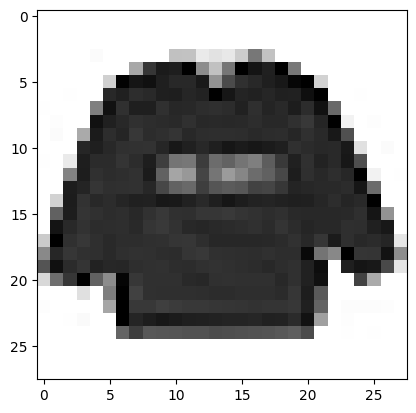

In [104]:
def get_image_arr(df, index):
    return df.iloc[index, :].to_numpy()

def plot_image(arr, x = 28, y = 28):
    img = arr.reshape(x, y)
    plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)

plot_image(get_image_arr(df_all_px, 0))

An interesting way to visualize the dataset using the `plot_image` function is seeing what the average clothing item looks like. This shows that the dataset contains a lot of redundant data - corners are always white, and the middle is usually black.

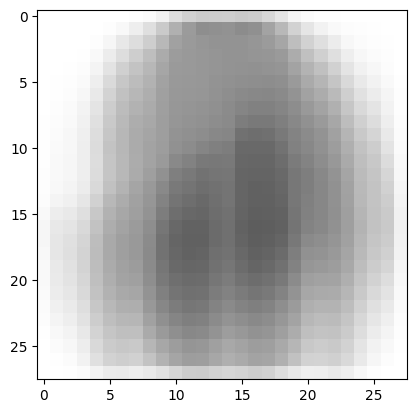

In [103]:
def plot_average_of(classes):
    plot_image(np.mean(df_all_px.loc[df_all['label'].isin(classes)].to_numpy(), axis=0))

plot_average_of([i for i in range(len(labels))])

## Dimensionality reduction

### PCA

Since the images contain a lot of redundant data, I have therefore decided to use PCA as a first step in the dimensionality reduction process, since a lot of the principal components will be insignificant.

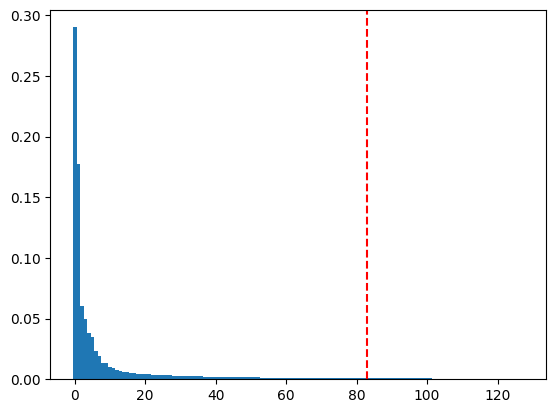

In [63]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RS)
pca.fit(df_all_px)
scree_data = pca.explained_variance_ratio_

# 90% of the variance should remain
thresh = 0.9

sum = 0
idx = 0
for idx, el in enumerate(scree_data):
    sum += el
    if sum > thresh:
        break

scree_len = 128
plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5)
# plt.yscale('log')
plt.bar(range(scree_len), scree_data[:scree_len], width=1)
plt.show()

As expected, the scree plot (with the x axis clipped to 128 from the original 784, to improve readability) shows that the vast majority of principal components are insignificant. 

The red line on the scree plot represents the point to which I have decided to reduce the dimensionality, so that 90% of the variance remains. 

An interesting approach to visualising the components is plotting them as images (0 - white, 1 - black), to see the patterns that they represent. I found the component with index 1 to be particularly entertaining, since it looks like a pair of trousers. Components with higher indices are much more messy - component 32 only barely resembles the silhouette of a clothing item, whereas component 512 is an almost complete mess.

(784,)


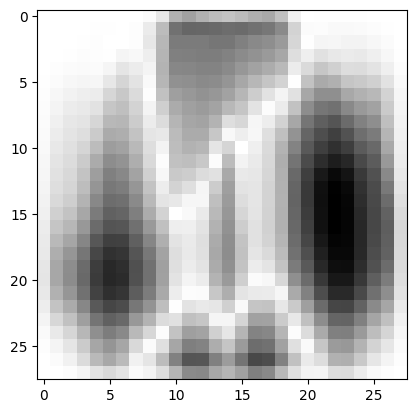

(784,)


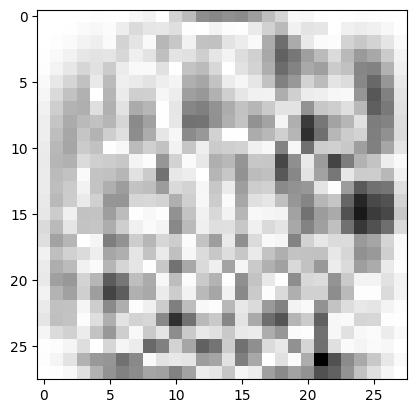

(784,)


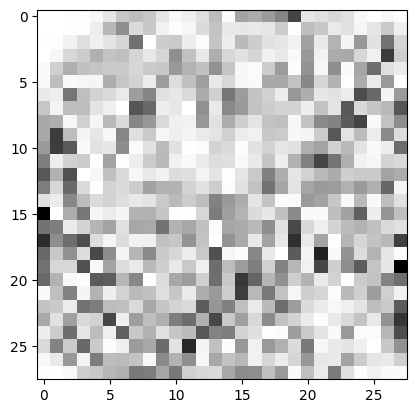

In [64]:
def plot_component(component_idx):
    def component_normalize(arr):
        return arr / np.max(arr)

    plot_image(component_normalize(np.abs(pca.components_[component_idx])))
    plt.show()

plot_component(1)
plot_component(32)
plot_component(512)

In [6]:
# Perform the reduction
n_components = idx + 1
pca = PCA(n_components=n_components, random_state=RS)
reduced_pca = pca.fit_transform(df_all_px)
print(f"Dimensionality reduced to: {n_components}")

Dimensionality reduced to: 84


### t-SNE

Next, to be able to visualise the dataset, I decided to apply some more advanced algorithms to the PCA-reduced dataset. The first of them I tried was t-SNE. It turned out, however, to be frustratingly slow, so in the experimental phase I used a random selection of 20% of the data.

In [9]:
# from sklearn.manifold import TSNE

# df_pick_ratio = 0.1
# # df_pick_ratio = 1.0
# df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

# tsne = TSNE(n_components=2, random_state=RS)
# reduced_tsne = tsne.fit_transform(reduced_pca[df_mask])

In [9]:
from matplotlib.colors import ListedColormap

def plot_2d(reduced, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=labels[i]) for i in labels]
    
    # Add legend
    plt.legend(handles=legend_handles, title='Categories', loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=df_all['label'][df_mask], cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

# plot_2d(reduced_tsne, df_mask)

t-SNE managed to separate some of the categories, but most of them remained jumbled together. Trousers and bags are very easy to distinguish, each in their own, well separated cluster. Sandals, ankle boots and sneakers are in three corners of one cluster. T-shirts/tops and dresses are somehow separated, but dresses are spread around T-shirts over two clusters. Pullovers, coats and shirts are a complete mess. 

With hopes of achieving better separation, I have decided to try out another algorithm, which I heard is faster and more efficient than t-SNE - UMAP.

### UMAP
UMAP did indeed prove to be much faster, which made experimenting with algorithm parameter values much easier. I have settled on `n_neighbors = 5` and `min_dist = 0.05`, since they seemed to provide a good balance, making the clusters concentrated but at the same time not splitting them into too many smaller subclusters.

In [94]:
from umap import UMAP

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(df_all_px), p=[df_pick_ratio, 1 - df_pick_ratio])

umap = UMAP(n_components=2, random_state=RS, n_neighbors=5, min_dist=0.05)
reduced_umap = umap.fit_transform(df_all_px[df_mask])

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


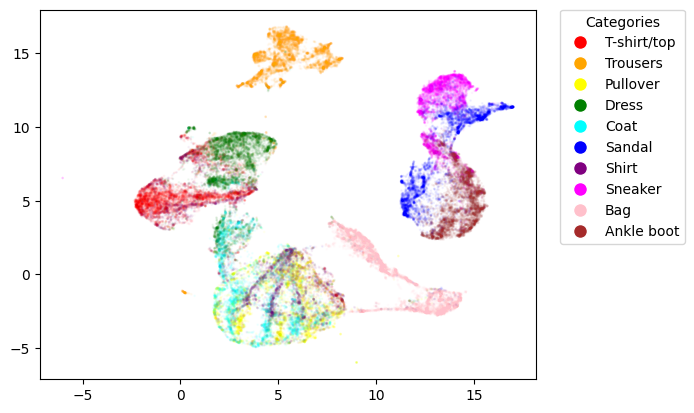

In [95]:
plot_2d(reduced_umap, df_mask)

The results produced by UMAP don't seem to be much better than those produced by t-SNE. It did however manage to make the clusters denser, and distinguished T-shirts/tops from dresses somewhat better.

I therefore conclude, that using those algorithms the dataset cannot be represented in 2d as well as e.g. the MNIST handwritten digit dataset. Clustering therefore needs to be performed in a higher dimensional space.

For visualisation purposes I will be using the t-SNE result - I find the sparser plot to be a bit more readable.

## Clustering

### KMeans
First, I decided to try the KMeans algorithm, since it is fast and easy to use, and good to use when we know how many clusters to expect - 10.

In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix

df_mask_all = np.ones(len(reduced_pca), dtype=bool)

kmeans = KMeans(n_clusters=10, random_state=RS)
kmeans.fit(df_all_px)

print(adjusted_rand_score(df_all['label'], kmeans.labels_))

0.3724010851004581


In [11]:
def plot_clusters(points, cluster_labels, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    plt.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

def plot_contingency_matrix(true_labels, predicted_labels):
    m = contingency_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(m)
    disp.plot()
    plt.show()

# plot_2d(reduced_umap, df_mask)
plot_clusters(reduced_umap, kmeans.labels_, df_mask_all)
plot_contingency_matrix(df_all['label'], kmeans.labels_)


NameError: name 'kmeans' is not defined

As we can see, the clustering didn't perform particularily well, achieving an adjustednd index of below 0.4. It clustered items with labels 1, 7, 9 (Trousers, Sneakers, Ankle boots) mostly correctly, but had problems tracking the more complex shapes of remainig clusters. This suggests that the clusters in our dataset aren't spherical, and we need to use a different method, such as density based or hierarchical clusterings.

In order to perform those more advanced algorithms, I decided to reduce the dimensionality of the dataset even further, using UMAP - to speed up the clustering process, while hopefully not losing too much information. I have played around with the parameters for this UMAP reduction, and I haven't been able to achieve better results than those provided by the current parameters.  

In [15]:
umap_cluster = UMAP(n_components=16, n_neighbors=5, min_dist=0.1)
reduced_umap_cluster = umap_cluster.fit_transform(reduced_pca)

### DBSCAN
I decided to first try density-based clusterings - the UMAP-reduced dataset in 2d looked like a lot of the clusters are distinguishable as areas of increased density, and so I concluded that the 16d reduced set I will be working on may exhibit similar properties. First of those algorithms was DBSCAN. It required a lot of parameter tweaking to achieve at least partially satisfactory results - again, I haven't been able to achieve better results that those with the current parameter values.

In [20]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.3, min_samples=1920)
dbscan.fit(reduced_umap_cluster)

print(np.unique(dbscan.labels_))

print(adjusted_rand_score(df_all['label'], dbscan.labels_))
print(f"Noise ratio: {(dbscan.labels_ == -1).sum() / len(dbscan.labels_)}")

[-1  0  1  2  3  4  5  6  7  8  9]
0.4850237041453177
Noise ratio: 0.060442857142857145


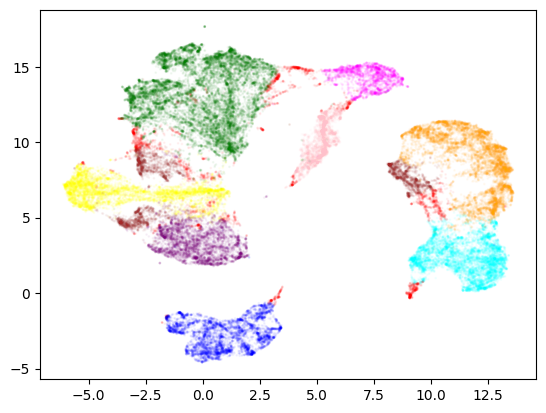

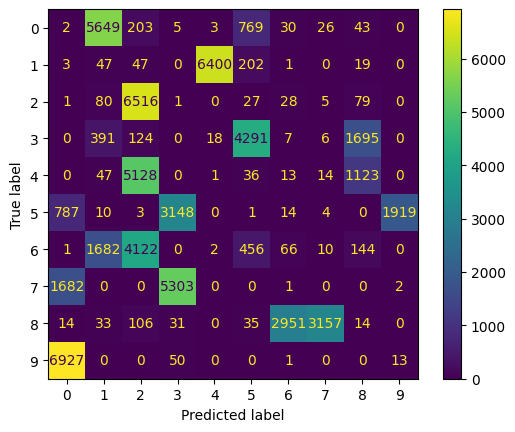

In [21]:
plot_clusters(reduced_umap[df_mask_all], dbscan.labels_, df_mask_all)
plot_contingency_matrix(df_all['label'][dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])

In [ ]:
from sklearn.cluster import SpectralClustering

df_pick_ratio = 0.1
df_mask_sc = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

sc = SpectralClustering(n_clusters=10, random_state=RS, n_neighbors=50)
sc.fit(reduced_umap_cluster[df_mask_sc])

print(adjusted_rand_score(df_all['label'][df_mask_sc], sc.labels_))

0.48914017437071233


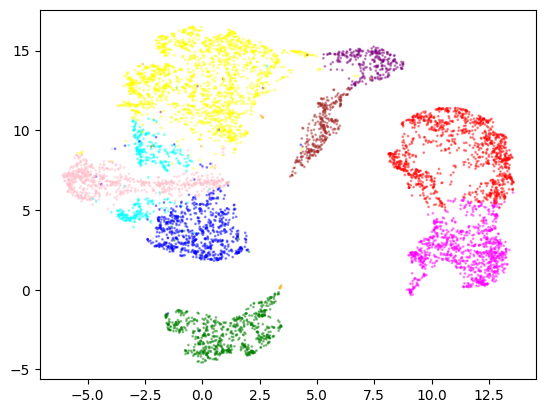

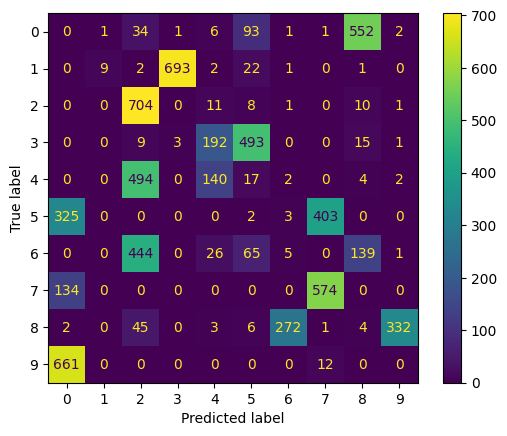

In [24]:
plot_clusters(reduced_umap[df_mask_sc], sc.labels_, df_mask_sc)
plot_contingency_matrix(df_all['label'][df_mask_sc], sc.labels_)

In [26]:
from sklearn.cluster import AgglomerativeClustering

df_pick_ratio = 0.25
df_mask_ac = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

ac = AgglomerativeClustering(n_clusters=10)
ac.fit(reduced_umap_cluster[df_mask_ac])

print(adjusted_rand_score(df_all['label'][df_mask_ac], ac.labels_))

0.4579039169332515


In [ ]:
plot_clusters(reduced_umap[df_mask_ac], ac.labels_, df_mask_ac)
plot_contingency_matrix(df_all['label'][df_mask_ac], ac.labels_)

## Classification
The task of splitting the dataset into training and testing has already been done for us by Kaggle. I wi

In [13]:
X_train = df_train_px
y_train = df_train['label']

X_test = df_test_px
y_test = df_test['label']

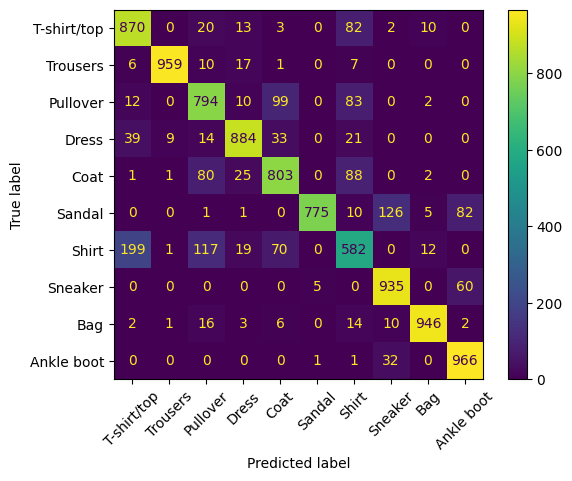

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.87      0.82      1000
    Trousers       0.99      0.96      0.97      1000
    Pullover       0.75      0.79      0.77      1000
       Dress       0.91      0.88      0.90      1000
        Coat       0.79      0.80      0.80      1000
      Sandal       0.99      0.78      0.87      1000
       Shirt       0.66      0.58      0.62      1000
     Sneaker       0.85      0.94      0.89      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.87      0.97      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m, display_labels=[labels[key] for key in labels])
disp.plot(xticks_rotation=45)
plt.show()
print(classification_report(y_test, predictions, target_names=[labels[key] for key in labels]))

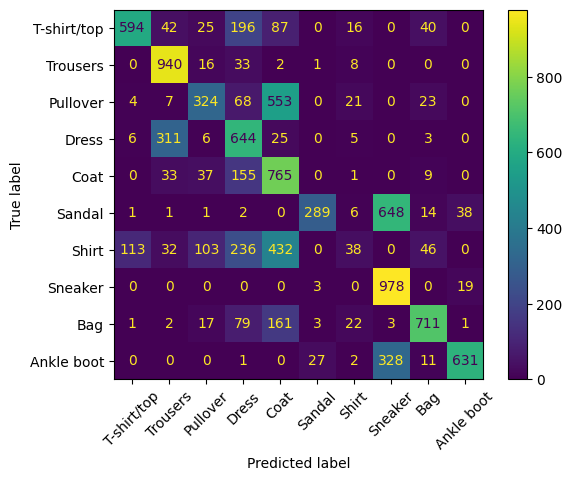

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.59      0.69      1000
    Trousers       0.69      0.94      0.79      1000
    Pullover       0.61      0.32      0.42      1000
       Dress       0.46      0.64      0.53      1000
        Coat       0.38      0.77      0.51      1000
      Sandal       0.89      0.29      0.44      1000
       Shirt       0.32      0.04      0.07      1000
     Sneaker       0.50      0.98      0.66      1000
         Bag       0.83      0.71      0.77      1000
  Ankle boot       0.92      0.63      0.75      1000

    accuracy                           0.59     10000
   macro avg       0.64      0.59      0.56     10000
weighted avg       0.64      0.59      0.56     10000



In [40]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m, display_labels=[labels[key] for key in labels])
disp.plot(xticks_rotation=45)
plt.show()
print(classification_report(y_test, predictions, target_names=[labels[key] for key in labels]))

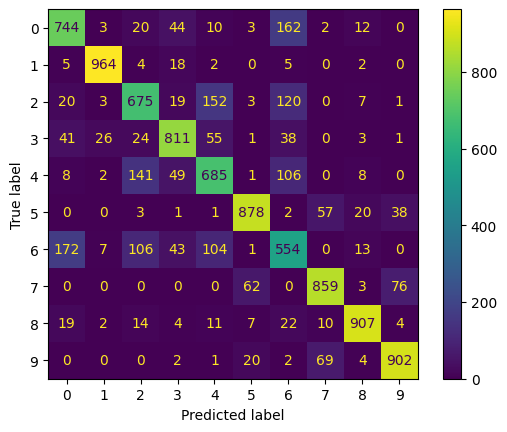

              precision    recall  f1-score   support

 T-shirt/top       0.74      0.74      0.74      1000
    Trousers       0.96      0.96      0.96      1000
    Pullover       0.68      0.68      0.68      1000
       Dress       0.82      0.81      0.81      1000
        Coat       0.67      0.69      0.68      1000
      Sandal       0.90      0.88      0.89      1000
       Shirt       0.55      0.55      0.55      1000
     Sneaker       0.86      0.86      0.86      1000
         Bag       0.93      0.91      0.92      1000
  Ankle boot       0.88      0.90      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [38]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=32)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(m)
disp.plot()
plt.show()
print(classification_report(y_test, predictions, target_names=[labels[key] for key in labels]))